<a href="https://colab.research.google.com/github/tsato-code/colab_notebooks/blob/main/pytorch_vsumm_reinforce_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Apr 20 15:49:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 関連リポジトリをクローン
%cd /content
!git clone https://github.com/SinDongHwan/pytorch-vsumm-reinforce.git sindonghwan
!git clone https://github.com/Harryjun/pytorch-vsumm-reinforce.git harryjun

/content
Cloning into 'sindonghwan'...
remote: Enumerating objects: 254, done.
remote: Total 254 (delta 0), reused 0 (delta 0), pack-reused 254
Receiving objects: 100% (254/254), 411.32 KiB | 2.28 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Cloning into 'harryjun'...
remote: Enumerating objects: 160, done.
remote: Total 160 (delta 0), reused 0 (delta 0), pack-reused 160
Receiving objects: 100% (160/160), 405.58 KiB | 2.20 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [3]:
# 動画ファイルをダウンロード
!pip install pytube
from pytube import YouTube
import os

data_dir = '/content/data/original/'
os.makedirs(data_dir, exist_ok=True)

# hot pepper beauty
out = YouTube('https://www.youtube.com/watch?v=rwt3oS_mFVQ').streams.first().download()
os.rename(out, data_dir+'test01.mp4')
# GREEN DAKARA
out = YouTube('https://www.youtube.com/watch?v=cShbQ2pQs94').streams.first().download()
os.rename(out, data_dir+'test02.mp4')
# ポカリスウェット
out = YouTube('https://www.youtube.com/watch?v=cKM2HQLK8Pg').streams.first().download()
os.rename(out, data_dir+'test03.mp4')

     |████████████████████████████████| 51kB 2.5MB/s 


In [4]:
# network/__init__.py をコメントアウト
text = r'''
# from CNN import *
# from DSN import *
# from RL import *
'''
with open('/content/sindonghwan/networks/__init__.py', 'w') as f:
    f.write(text)

# utils/KTS/__init__.py をコメントアウト
text = r'''
# from file_process import *
# from knapsack import *
# from vsum_tool import *
'''
with open('/content/sindonghwan/utils/KTS/__init__.py', 'w') as f:
    f.write(text)

# utils/KTS/cpd_autp.py 2行目 from .cpd_nonlin import cpd_nonlin に変更（ドットを追加）
text = r'''
import numpy as np
from .cpd_nonlin import cpd_nonlin

def cpd_auto(K, ncp, vmax, desc_rate=1, **kwargs):
    """Main interface
    
    Detect change points automatically selecting their number
        K       - kernel between each pair of frames in video
        ncp     - maximum ncp
        vmax    - special parameter
    Optional arguments:
        lmin     - minimum segment length
        lmax     - maximum segment length
        desc_rate - rate of descriptor sampling (vmax always corresponds to 1x)

    Note:
        - cps are always calculated in subsampled coordinates irrespective to
            desc_rate
        - lmin and m should be in agreement
    ---
    Returns: (cps, costs)
        cps   - best selected change-points
        costs - costs for 0,1,2,...,m change-points
        
    Memory requirement: ~ (3*N*N + N*ncp)*4 bytes ~= 16 * N^2 bytes
    That is 1,6 Gb for the N=10000.
    """
    m = ncp
    (_, scores) = cpd_nonlin(K, m, backtrack=False, **kwargs)
    
    N = K.shape[0]
    N2 = N*desc_rate  # length of the video before subsampling
    
    penalties = np.zeros(m+1)
    # Prevent division by zero (in case of 0 changes)
    ncp = np.arange(1, m+1)
    penalties[1:] = (vmax*ncp/(2.0*N2))*(np.log(float(N2)/ncp)+1)
    
    costs = scores/float(N) + penalties
    m_best = np.argmin(costs)
    (cps, scores2) = cpd_nonlin(K, m_best, **kwargs)

    return (cps, costs)
    

# ------------------------------------------------------------------------------
# Extra functions (currently not used)

def estimate_vmax(K_stable):
    """K_stable - kernel between all frames of a stable segment"""
    n = K_stable.shape[0]
    vmax = np.trace(centering(K_stable)/n)
    return vmax


def centering(K):
    """Apply kernel centering"""
    mean_rows = np.mean(K, 1)[:, np.newaxis]
    return K - mean_rows - mean_rows.T + np.mean(mean_rows)


def eval_score(K, cps):
    """ Evaluate unnormalized empirical score
        (sum of kernelized scatters) for the given change-points """
    N = K.shape[0]
    cps = [0] + list(cps) + [N]
    V1 = 0
    V2 = 0
    for i in range(len(cps)-1):
        K_sub = K[cps[i]:cps[i+1], :][:, cps[i]:cps[i+1]]
        V1 += np.sum(np.diag(K_sub))
        V2 += np.sum(K_sub) / float(cps[i+1] - cps[i])
    return (V1 - V2)


def eval_cost(K, cps, score, vmax):
    """ Evaluate cost function for automatic number of change points selection
    K      - kernel between all frames
    cps    - selected change-points
    score  - unnormalized empirical score (sum of kernelized scatters)
    vmax   - vmax parameter"""
    
    N = K.shape[0]
    penalty = (vmax*len(cps)/(2.0*N))*(np.log(float(N)/len(cps))+1)
    return score/float(N) + penalty
'''
with open('/content/sindonghwan/utils/KTS/cpd_auto.py', 'w') as f:
    f.write(text)

# utils/KTS/cpd_nonlin.py をすべて https://github.com/li-plus/DSNet/blob/main/src/kts/cpd_nonlin.py と置き換え
text = r'''
import numpy as np


def calc_scatters(K):
    """Calculate scatter matrix: scatters[i,j] = {scatter of the sequence with
    starting frame i and ending frame j}
    """
    n = K.shape[0]
    K1 = np.cumsum([0] + list(np.diag(K)))
    K2 = np.zeros((n + 1, n + 1))
    # TODO: use the fact that K - symmetric
    K2[1:, 1:] = np.cumsum(np.cumsum(K, 0), 1)

    diagK2 = np.diag(K2)

    i = np.arange(n).reshape((-1, 1))
    j = np.arange(n).reshape((1, -1))
    scatters = (
            K1[1:].reshape((1, -1)) - K1[:-1].reshape((-1, 1)) -
            (diagK2[1:].reshape((1, -1)) + diagK2[:-1].reshape((-1, 1)) -
             K2[1:, :-1].T - K2[:-1, 1:]) /
            ((j - i + 1).astype(np.float32) + (j == i - 1).astype(np.float32))
    )
    scatters[j < i] = 0

    return scatters


def cpd_nonlin(K, ncp, lmin=1, lmax=100000, backtrack=True, verbose=True,
               out_scatters=None):
    """Change point detection with dynamic programming
    :param K: Square kernel matrix
    :param ncp: Number of change points to detect (ncp >= 0)
    :param lmin: Minimal length of a segment
    :param lmax: Maximal length of a segment
    :param backtrack: If False - only evaluate objective scores (to save memory)
    :param verbose: If true, print verbose message
    :param out_scatters: Output scatters
    :return: Tuple (cps, obj_vals)
        - cps - detected array of change points: mean is thought to be constant
            on [ cps[i], cps[i+1] )
        - obj_vals - values of the objective function for 0..m changepoints
    """
    m = int(ncp)  # prevent numpy.int64

    n, n1 = K.shape
    assert n == n1, 'Kernel matrix awaited.'
    assert (m + 1) * lmin <= n <= (m + 1) * lmax
    assert 1 <= lmin <= lmax

    if verbose:
        print('Precomputing scatters...')
    J = calc_scatters(K)

    if out_scatters is not None:
        out_scatters[0] = J

    if verbose:
        print('Inferring best change points...')
    # I[k, l] - value of the objective for k change-points and l first frames
    I = 1e101 * np.ones((m + 1, n + 1))
    I[0, lmin:lmax] = J[0, lmin - 1:lmax - 1]

    if backtrack:
        # p[k, l] --- 'previous change' --- best t[k] when t[k+1] equals l
        p = np.zeros((m + 1, n + 1), dtype=int)
    else:
        p = np.zeros((1, 1), dtype=int)

    for k in range(1, m + 1):
        for l in range((k + 1) * lmin, n + 1):
            tmin = max(k * lmin, l - lmax)
            tmax = l - lmin + 1
            c = J[tmin:tmax, l - 1].reshape(-1) + \
                I[k - 1, tmin:tmax].reshape(-1)
            I[k, l] = np.min(c)
            if backtrack:
                p[k, l] = np.argmin(c) + tmin

    # Collect change points
    cps = np.zeros(m, dtype=int)

    if backtrack:
        cur = n
        for k in range(m, 0, -1):
            cps[k - 1] = p[k, cur]
            cur = cps[k - 1]

    scores = I[:, n].copy()
    scores[scores > 1e99] = np.inf
    return cps, scores
'''
with open('/content/sindonghwan/utils/KTS/cpd_nonlin.py', 'w') as f:
    f.write(text)

# utils/generate_dataset.py の90行目を os.makedirs に変更
# utils/generate_dataset.py の145行目を summeデータセットのディレクトリに変更
text = r'''
"""
    Generate Dataset

    1. Converting video to frames
    2. Extracting features
    3. Getting change points
    4. User Summary ( for evaluation )

"""
import os, sys
sys.path.append('../')
from networks.CNN import ResNet
from utils.KTS.cpd_auto import cpd_auto
from tqdm import tqdm
import math
import cv2
import numpy as np
import h5py

class Generate_Dataset:
    def __init__(self, video_path, save_path):
        self.resnet = ResNet()
        self.dataset = {}
        self.video_list = []
        self.video_path = ''
        self.frame_root_path = './frames'
        self.h5_file = h5py.File(save_path, 'w')

        self._set_video_list(video_path)

    def _set_video_list(self, video_path):
        if os.path.isdir(video_path):
            self.video_path = video_path
            self.video_list = os.listdir(video_path)
            self.video_list.sort()
        else:
            self.video_path = ''
            self.video_list.append(video_path)

        for idx, file_name in enumerate(self.video_list):
            self.dataset['video_{}'.format(idx+1)] = {}
            self.h5_file.create_group('video_{}'.format(idx+1))


    def _extract_feature(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (224, 224))
        res_pool5 = self.resnet(frame)
        frame_feat = res_pool5.cpu().data.numpy().flatten()

        return frame_feat

    def _get_change_points(self, video_feat, n_frame, fps):
        n = n_frame / fps
        m = int(math.ceil(n/2.0))
        K = np.dot(video_feat, video_feat.T)
        change_points, _ = cpd_auto(K, m, 1)
        change_points = np.concatenate(([0], change_points, [n_frame-1]))

        temp_change_points = []
        for idx in range(len(change_points)-1):
            segment = [change_points[idx], change_points[idx+1]-1]
            if idx == len(change_points)-2:
                segment = [change_points[idx], change_points[idx+1]]

            temp_change_points.append(segment)
        change_points = np.array(list(temp_change_points))

        temp_n_frame_per_seg = []
        for change_points_idx in range(len(change_points)):
            n_frame = change_points[change_points_idx][1] - change_points[change_points_idx][0]
            temp_n_frame_per_seg.append(n_frame)
        n_frame_per_seg = np.array(list(temp_n_frame_per_seg))

        return change_points, n_frame_per_seg

    # TODO : save dataset
    def _save_dataset(self):
        pass

    def generate_dataset(self):
        for video_idx, video_filename in enumerate(tqdm(self.video_list)):
            video_path = video_filename
            if os.path.isdir(self.video_path):
                video_path = os.path.join(self.video_path, video_filename)

            video_basename = os.path.basename(video_path).split('.')[0]

            if not os.path.exists(os.path.join(self.frame_root_path, video_basename)):
                os.makedirs(os.path.join(self.frame_root_path, video_basename))

            video_capture = cv2.VideoCapture(video_path)

            fps = video_capture.get(cv2.CAP_PROP_FPS)
            n_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

            frame_list = []
            picks = []
            video_feat = None
            video_feat_for_train = None
            for frame_idx in tqdm(range(n_frames-1)):
                success, frame = video_capture.read()
                if success:
                    frame_feat = self._extract_feature(frame)

                    if frame_idx % 15 == 0:
                        picks.append(frame_idx)

                        if video_feat_for_train is None:
                            video_feat_for_train = frame_feat
                        else:
                            video_feat_for_train = np.vstack((video_feat_for_train, frame_feat))

                    if video_feat is None:
                        video_feat = frame_feat
                    else:
                        video_feat = np.vstack((video_feat, frame_feat))

                    img_filename = "{}.jpg".format(str(frame_idx).zfill(5))
                    cv2.imwrite(os.path.join(self.frame_root_path, video_basename, img_filename), frame)

                else:
                    break

            video_capture.release()

            change_points, n_frame_per_seg = self._get_change_points(video_feat, n_frames, fps)

            # self.dataset['video_{}'.format(video_idx+1)]['frames'] = list(frame_list)
            # self.dataset['video_{}'.format(video_idx+1)]['features'] = list(video_feat)
            # self.dataset['video_{}'.format(video_idx+1)]['picks'] = np.array(list(picks))
            # self.dataset['video_{}'.format(video_idx+1)]['n_frames'] = n_frames
            # self.dataset['video_{}'.format(video_idx+1)]['fps'] = fps
            # self.dataset['video_{}'.format(video_idx+1)]['change_points'] = change_points
            # self.dataset['video_{}'.format(video_idx+1)]['n_frame_per_seg'] = n_frame_per_seg

            self.h5_file['video_{}'.format(video_idx+1)]['features'] = list(video_feat_for_train)
            self.h5_file['video_{}'.format(video_idx+1)]['picks'] = np.array(list(picks))
            self.h5_file['video_{}'.format(video_idx+1)]['n_frames'] = n_frames
            self.h5_file['video_{}'.format(video_idx+1)]['fps'] = fps
            self.h5_file['video_{}'.format(video_idx+1)]['change_points'] = change_points
            self.h5_file['video_{}'.format(video_idx+1)]['n_frame_per_seg'] = n_frame_per_seg

if __name__ == "__main__":
    # gen = Generate_Dataset('/data/video_summarization/dataset_SumMe/videos/Air_Force_One.mp4', 'summe_dataset.h5')
    gen = Generate_Dataset('/content/videos/Air_Force_One.mp4', 'summe_dataset.h5')
    gen.generate_dataset()
    gen.h5_file.close()
'''
with open('/content/sindonghwan/utils/generate_dataset.py', 'w') as f:
    f.write(text)

In [5]:
# ファイルコピー
!cp /content/harryjun/video_forward2.py /content/sindonghwan
!cp /content/harryjun/file_process.py /content/sindonghwan
!cp /content/harryjun/knapsack.py /content/sindonghwan
!cp /content/harryjun/vsum_tool.py /content/sindonghwan
!cp /content/harryjun/models.py /content/sindonghwan
!cp /content/harryjun/rewards.py /content/sindonghwan
!cp /content/harryjun/vsum_tools.py /content/sindonghwan
!mv /content/sindonghwan/utils/generate_dataset.py /content/sindonghwan/utils/__generate_dataset.py
!cp /content/harryjun/generate_dataset.py /content/sindonghwan/utils
!cp /content/harryjun/feature_extractor.py /content/sindonghwan

In [6]:
# sindonghwan/utils/generate_dataset.py の97行目をmakedirsに変更
text = r'''
"""
    Generate Dataset

    1. Converting video to frames
    2. Extracting features
    3. Getting change points
    4. User Summary ( for evaluation )

"""
import os, sys
sys.path.append('../')
from utils.KTS.cpd_auto import cpd_auto
from tqdm import tqdm
import math
import cv2
import numpy as np
import h5py
from feature_extractor import YouTube8MFeatureExtractor
from PIL import Image
import argparse
parser = argparse.ArgumentParser("name")
###
parser.add_argument('--video-dir', default='', help='')
parser.add_argument('--output-dir', default='', help='')

class Generate_Dataset:
    def __init__(self, video_path, save_path,frame_dir,train_data):
        self.dataset = {}
        self.video_list = []
        self.video_path = ''
        self.frame_root_path = frame_dir
        self.h5_file = h5py.File(save_path, 'w')
        self.extractor = YouTube8MFeatureExtractor()
        self._set_video_list(video_path)
        self.train_data = train_data

    def _set_video_list(self, video_path):
        if os.path.isdir(video_path):
            self.video_path = video_path
            self.video_list = os.listdir(video_path)
            self.video_list.sort()
        else:
            self.video_path = ''
            self.video_list.append(video_path)

        for idx, file_name in enumerate(self.video_list):
            self.dataset['video_{}'.format(idx+1)] = {}
            self.h5_file.create_group('video_{}'.format(idx+1))


    def _extract_feature(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        #frame = cv2.resize(frame, (224, 224))
        res_pool5 = self.extractor.extract_rgb_frame_features(frame)
        #res_pool5 = self.resnet(frame)
        frame_feat =res_pool5 #res_pool5.cpu().data.numpy().flatten()
        #print(frame_feat.shape)
        return frame_feat

    def _get_change_points(self, video_feat, n_frame, fps):
        n = n_frame / fps
        m = int(math.ceil(n/2.0))
        K = np.dot(video_feat, video_feat.T)
        change_points, _ = cpd_auto(K, m, 1)
        change_points = np.concatenate(([0], change_points, [n_frame-1]))

        temp_change_points = []
        for idx in range(len(change_points)-1):
            segment = [change_points[idx], change_points[idx+1]-1]
            if idx == len(change_points)-2:
                segment = [change_points[idx], change_points[idx+1]]

            temp_change_points.append(segment)
        change_points = np.array(list(temp_change_points))

        temp_n_frame_per_seg = []
        for change_points_idx in range(len(change_points)):
            n_frame = change_points[change_points_idx][1] - change_points[change_points_idx][0] +1
            temp_n_frame_per_seg.append(n_frame)
        n_frame_per_seg = np.array(list(temp_n_frame_per_seg))

        return change_points, n_frame_per_seg

    # TODO : save dataset
    def _save_dataset(self):
        pass

    def generate_dataset(self):
        for video_idx, video_filename in enumerate(tqdm(self.video_list)):
            video_path = video_filename
            if os.path.isdir(self.video_path):
                video_path = os.path.join(self.video_path, video_filename)

            video_basename = os.path.basename(video_path).split('.')[0]
            print(video_filename)
            if not os.path.exists(os.path.join(self.frame_root_path, video_basename)):
                os.makedirs(os.path.join(self.frame_root_path, video_basename))

            video_capture = cv2.VideoCapture(video_path)
            video_dir = video_path
            fps = video_capture.get(cv2.CAP_PROP_FPS)
            n_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

            frame_list = []
            picks = []
            video_feat = None
            video_feat_for_train = None
            print(n_frames)
            for frame_idx in tqdm(range(n_frames)):
                success, frame = video_capture.read()
                if success:
                    frame_feat = self._extract_feature(frame)

                    if frame_idx % 15 == 0:
                        picks.append(frame_idx)

                        if video_feat_for_train is None:
                            video_feat_for_train = frame_feat
                        else:
                            video_feat_for_train = np.vstack((video_feat_for_train, frame_feat))

                    if video_feat is None:
                        video_feat = frame_feat
                    else:
                        video_feat = np.vstack((video_feat, frame_feat))
                    #train_dataset
                    if self.train_data:
                        img_filename = "{}.jpg".format(str(frame_idx).zfill(6))
                        if not os.path.exists(os.path.join(self.frame_root_path, video_basename, img_filename)):
                            cv2.imwrite(os.path.join(self.frame_root_path, video_basename, img_filename), frame)

                    

                else:
                    break

            video_capture.release()

            change_points, n_frame_per_seg = self._get_change_points(video_feat, n_frames, fps)

            # self.dataset['video_{}'.format(video_idx+1)]['frames'] = list(frame_list)
            # self.dataset['video_{}'.format(video_idx+1)]['features'] = list(video_feat)
            # self.dataset['video_{}'.format(video_idx+1)]['picks'] = np.array(list(picks))
            # self.dataset['video_{}'.format(video_idx+1)]['n_frames'] = n_frames
            # self.dataset['video_{}'.format(video_idx+1)]['fps'] = fps
            # self.dataset['video_{}'.format(video_idx+1)]['change_points'] = change_points
            # self.dataset['video_{}'.format(video_idx+1)]['n_frame_per_seg'] = n_frame_per_seg

            self.h5_file['video_{}'.format(video_idx+1)]['features'] = list(video_feat_for_train)
            self.h5_file['video_{}'.format(video_idx+1)]['picks'] = np.array(list(picks))
            self.h5_file['video_{}'.format(video_idx+1)]['n_frames'] = n_frames
            self.h5_file['video_{}'.format(video_idx+1)]['fps'] = fps
            self.h5_file['video_{}'.format(video_idx + 1)]['video_name'] = video_filename.split('.')[0]
            self.h5_file['video_{}'.format(video_idx+1)]['change_points'] = change_points
            self.h5_file['video_{}'.format(video_idx+1)]['n_frame_per_seg'] = n_frame_per_seg
            self.h5_file['video_{}'.format(video_idx + 1)]['video_dir'] = video_dir


if __name__ == "__main__":
    args = parser.parse_args()
    video = args.video_dir
    output = args.output_dir
    frame_dir="./frames"
    gen = Generate_Dataset(video,output,frame_dir)
    gen.generate_dataset()
    gen.h5_file.close()
'''
with open('/content/sindonghwan/utils/generate_dataset.py', 'w') as f:
    f.write(text)

In [7]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 34kB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 3.8MB 74.1MB/s 
     |████████████████████████████████| 512kB 50.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=759c898f6429b4f084f5199164f7182ec3ab83ddeea59122732e510ffc6086cf
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [8]:
# 特徴量抽出
%cd /content/sindonghwan
!python video_forward2.py \
    --makedatasets \
    --dataset /content/data/hoge_piyo_01.h5 \
    --video-dir /content/data/original \
    --frm-dir /content/data/frames

/content/sindonghwan
>> Downloading yt8m_pca.tgz 100.0%Succesfully downloaded yt8m_pca.tgz 15654272 bytes.
>> Downloading inception-2015-12-05.tgz 100.0%Succesfully downloaded inception-2015-12-05.tgz 88931400 bytes.

2021-04-20 15:52:03.915548: W tensorflow/core/framework/op_def_util.cc:357] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

2021-04-20 15:52:04.035190: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-04-20 15:52:04.036543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-20 15:52:04.037152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0


In [10]:
import h5py
# ファイル内容を確認
h5_file_name = '/content/data/hoge_piyo_01.h5'
with h5py.File(h5_file_name, 'r') as f:
    for i, key in enumerate(sorted(f.keys())):
        print(f[key], f[key].keys())
        print(f[key+'/video_dir'].value)
        print(f[key+'/video_name'].value)
        print(f[key+'/picks'].value)
        print(f[key+'/n_frames'][...])
        print(f[key+'/change_points'].value)
        print(f[key+'/features'].shape) # => (332, 1024)
        # 動画のフレーム数4965を15フレームごとに特徴作成して長さ332を得る
        # 1024は1フレームの特徴次元らしい感じ

        print(type(f[key+'/features']))
        print(f[key+'/features'][0])
        print(f[key+'/features'][0].shape)
        print(f[key+'/features'][...])
        # print(f[key+'/gtscore'][...])
        # print(f[key+'/gtscore'][...].size * 15 - 1)
        print(f[key+'/change_points'][...])
        # print(f[key+'/change_points_score'].shape)
        # print(f[key+'/change_points_score'][...]) # => [[i]*15 for i in [1, 2, 3]]が出てくる
        if i== 0: 
            break

<HDF5 group "/video_1" (8 members)> <KeysViewHDF5 ['change_points', 'features', 'fps', 'n_frame_per_seg', 'n_frames', 'picks', 'video_dir', 'video_name']>
/content/data/original/test01.mp4
test01
[  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375 390 405 420 435 450 465 480 495 510 525
 540 555 570 585 600 615 630 645 660 675 690 705]
720
[[  0  29]
 [ 30  72]
 [ 73 107]
 [108 174]
 [175 201]
 [202 231]
 [232 253]
 [254 308]
 [309 346]
 [347 389]
 [390 433]
 [434 530]
 [531 571]
 [572 659]
 [660 678]
 [679 699]
 [700 719]]
(48, 1024)
<class 'h5py._hl.dataset.Dataset'>
[-0.48983252  0.4729608  -0.6805981  ... -0.01506163 -0.16160558
 -0.31701276]
(1024,)
[[-0.48983252  0.4729608  -0.6805981  ... -0.01506163 -0.16160558
  -0.31701276]
 [-0.94521797  0.5801306  -0.5915423  ... -0.90037405 -0.12235248
   0.01211861]
 [ 0.02842593  1.1433501  -0.38773078 ... -0.9326475   0.7152781
   0.3119357 ]
 ...
 [-0.15739292  0.5816016  -0.6289593

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  # This is added back by InteractiveShellApp.init_path()


In [11]:
!mkdir -p /content/logs/videolog
!python3 video_forward2.py \
    --makescore \
    --gpu 0 \
    --dataset /content/data/hoge_piyo_01.h5 \
    --save-dir /content/logs/videolog/

Args:Namespace(dataset='/content/data/hoge_piyo_01.h5', fps=30, frm_dir=None, gpu='0', height=480, hidden_dim=256, input_dim=1024, makedatasets=False, makescore=True, model='', num_layers=1, rnn_cell='lstm', save_dir='/content/logs/videolog/', save_name='summary.mp4', seed=1, split=None, split_id=0, summary=False, train_data=False, use_cpu=False, video_dir=None, width=640)
Currently using GPU 0
Initialize dataset /content/data/hoge_piyo_01.h5
['video_1', 'video_2', 'video_3']
# total videos 3. # test videos 3
Initialize model
Model size: 2.62605M
Evaluate
==> Test
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
(720,)
(847,)
(900,)
Summary


In [12]:
# ファイル内容を確認
h5_file_name = '/content/logs/videolog/result.h5'
with h5py.File(h5_file_name, 'r') as f:
    for i, key in enumerate(sorted(f.keys())):
        print(f[key], f[key].keys())
        print(f[key+'/video_dir'].value)
        print(f[key+'/video_name'].value)
        print(f[key+'/score'].shape)
        print(f[key+'/score'].value)
        # print(f[key+'/n_frames'][...])
        # print(f[key+'/change_points'].value)
        # print(f[key+'/features'].shape)
        # print(type(f[key+'/features']))
        # print(f[key+'/features'][0])
        # print(f[key+'/features'][0].shape)
        # print(f[key+'/features'][...])
        # print(f[key+'/gtscore'][...])
        # print(f[key+'/gtscore'][...].size * 15 - 1)
        # print(f[key+'/change_points'][...])
        # print(f[key+'/change_points_score'].shape)
        # print(f[key+'/change_points_score'][...]) # => [[i]*15 for i in [1, 2, 3]]が出てくる
        importance_score = f[key+'/score'].value
        if i== 0: 
            break

<HDF5 group "/video_1" (5 members)> <KeysViewHDF5 ['fps', 'machine_summary', 'score', 'video_dir', 'video_name']>
/content/data/original/test01.mp4
test01
(48,)
[0.5585587  0.54738796 0.5098342  0.5316246  0.54321384 0.57679033
 0.577996   0.5704023  0.47434843 0.4798721  0.5068153  0.5014547
 0.490105   0.4581704  0.49230954 0.47175768 0.5000705  0.5076062
 0.51941496 0.5161429  0.51078427 0.49048293 0.48206168 0.47545728
 0.5125353  0.5222031  0.51496106 0.49473757 0.472067   0.47266772
 0.48404643 0.50142336 0.51033974 0.49573106 0.48362947 0.4984296
 0.49276486 0.48297322 0.508631   0.52618986 0.5233429  0.52909875
 0.5424692  0.523534   0.5178163  0.51474065 0.47125265 0.46299607]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


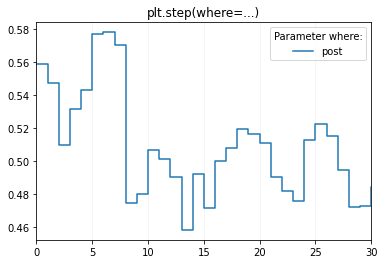

In [18]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(importance_score))
y = importance_score

# plt.step(x, y + 2, label='pre (default)')
# plt.plot(x, y + 2, 'o--', color='grey', alpha=0.3)

# plt.step(x, y + 1, where='mid', label='mid')
# plt.plot(x, y + 1, 'o--', color='grey', alpha=0.3)

plt.step(x, y, where='post', label='post')
# plt.plot(x, y, 'o--', color='grey', alpha=0.3)

plt.grid(axis='x', color='0.95')
plt.legend(title='Parameter where:')
plt.title('plt.step(where=...)')
plt.xlim(0, 30)
plt.show()

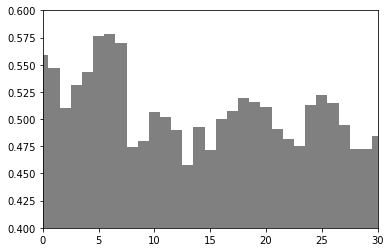

In [17]:
plt.bar(x, y, width=1.0, color='gray', linewidth=0)
plt.ylim(0.4, 0.6)
plt.xlim(0, 30)
plt.show()